# Data paths

In [88]:
import pickle
from collections import defaultdict
from rnamodif.inference import predictions_to_read_predictions

#triplets of path-nickname-label
exp_data  = [
    ('20180327_1102_K562_5EU_0_unlabeled_run','nanoid_neg_1', 0),
    ('20180514_1541_K562_5EU_1440_labeled_II_run','nanoid_pos_2', 1),
    
    # ('20210128_hsa_dRNA_HeLa_5EU_2hr_Ars_0030m_5P_2', 'Ars30', 1),
    # ('20210202_hsa_dRNA_HeLa_5EU_2hr_NoArs_0090m_5P_2', 'Noars90', 0),
    ('20201215_hsa_dRNA_HeLa_5EU_2hr_Ars_0060m_5P_1', 'Ars60', 1),
    # ('20210202_hsa_dRNA_HeLa_5EU_2hr_NoArs_0060m_5P_2', 'Noars60', 0),
    ('20210208_hsa_dRNA_HeLa_5EU_1hr_ctrl_0000m_5P_2', 'Noars0', 0),
]

exp_to_preds = {}
exp_to_label = {}
for path, nickname, label in exp_data:
    #TODO remove relative path
    with open(f'./inference/{path}/reads.pickle','rb') as f:
        exp_to_preds[nickname] = pickle.load(f)
        
        #Needed for pooling other than default (mean)
#         with open(f'./inference/{path}/windows.pickle','rb') as f:
#             preds = pickle.load(f)
#         exp_to_preds[nickname] = predictions_to_read_predictions(preds, pooling='max')
        
        exp_to_label[nickname] = label
        print(nickname, len(exp_to_preds[nickname]))



nanoid_neg_1 13787
nanoid_pos_2 15120
Ars60 1428000
Noars0 1400288


# Predicted score distribution

nanoid_neg_1 13787
13787


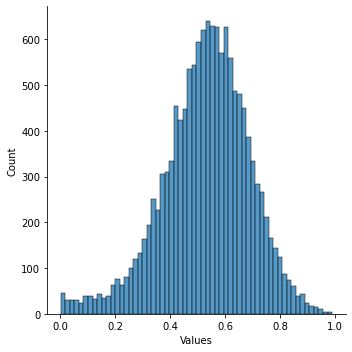

nanoid_pos_2 15120
15120


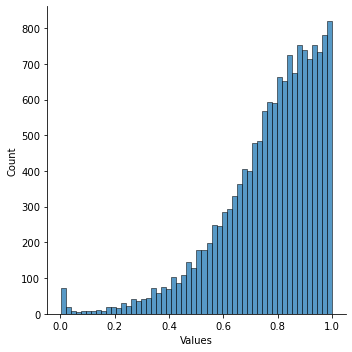

Ars60 1428000
1428000


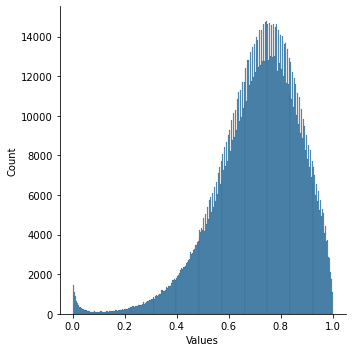

Noars0 1400288
1400288


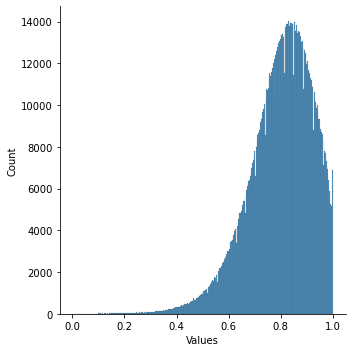

In [89]:
import seaborn
import matplotlib.pyplot as plt
import pandas as pd

# Convert the array to a pandas DataFrame
for k,v in exp_to_preds.items():
    print(k, len(v))
    print(len(v))
    data_array = list(v.values())
    #TODO fix last element
    data_df = pd.DataFrame(data_array[:-1], columns=["Values"])
    # seaborn.violinplot(x=data_df["Values"])
    seaborn.displot(x=data_df["Values"])
    plt.show()
    
    
    

# AUROC

In [33]:
from matplotlib import pyplot as plt
from sklearn import metrics
import numpy as np

def plot_roc(exp_to_preds, title=''):
    labels = []
    predictions = [] 
    exps = list(exp_to_preds.keys())
    for exp, preds in exp_to_preds.items():
        for pred in preds.values():
            predictions.append(pred)
            labels.append(exp_to_label[exp])
            
    if(np.isnan(predictions).any()):
        print('Warning: Nan found in predictions, setting to 0')
        print(np.where(np.isnan(predictions)))
        for nan_idx in np.where(np.isnan(predictions))[0]:
            predictions[nan_idx] = 0.0
    
    fpr, tpr, thresholds = metrics.roc_curve(labels, predictions)
    cutoff_1 = thresholds[np.argmax(tpr-fpr)]
    cutoff_1_tpr = tpr[np.argmax(tpr-fpr)]
    
    cutoff_2 = thresholds[np.argmin((1-tpr) ** 2 + fpr ** 2)]
    cutoff_2_tpr = tpr[np.argmin((1-tpr) ** 2 + fpr ** 2)]
    
    try:
        auc = metrics.roc_auc_score(labels, predictions)
        precision, recall, thresholds = metrics.precision_recall_curve(labels, predictions)
    except ValueError:
        print('AUC not defined')
        auc=0
    print(auc)
    exps = str(exps[:len(exps)//2])+'\n'+str(exps[len(exps)//2:]) #For nice legend printing
    plt.plot(fpr, tpr, label = f'{exps} \n AUC %.3f CUTOFFS {str(cutoff_1)[:4]} (tpr {str(cutoff_1_tpr)[:4]}) or {str(cutoff_2)[:4]} (tpr {str(cutoff_2_tpr)[:4]})' % auc)
    plt.title(f'{title}')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend(loc='center left', bbox_to_anchor=(1,0.5), prop={'size':10})
    

    plt.xlim([0, 1.05])
    plt.ylim([0, 1.05])

0.8527132256519542


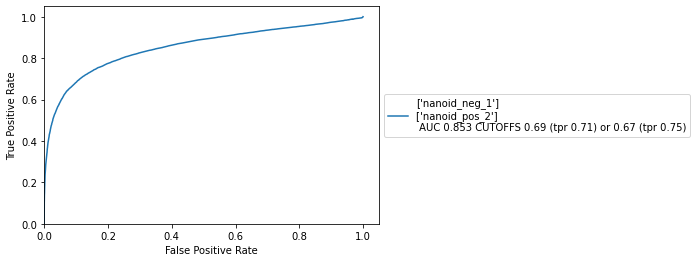

In [34]:
plot_roc(exp_to_preds)